# Covid-19 Analysis

## Overview

With all the talk of Covid-19 in the news, I've decided to look at the data. The data of note was that published on NHS England website https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/. The numbers presented at the daily government briefings are the number reported on that day, rather than the date when the death occurred. This data is slightly different as it reports on date of death, so may be a little more precise with regards to when the peak is happening. However, there is a lag in when deaths are reported so we will hopefully try to take this into account with a naive estimate of real counts.  In addition to this the numbers being reported by date, they are also reported by age, by region,and by NHS trust. I don't think equivalent datasets are available for Wales, Scotland and Northern Ireland, so these are for England only.

The data needed for running this analysis can be downloaded from the web to a local machine by running the following command from prompt :

```
python 00_Download_Excel.py
```

## Raw Data Analysis

Firstly we load the data in :

In [1]:
import pathlib
import re
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
from IPython.display import display

# Set up display options for pandas in workbook

pd.options.display.max_columns = None

# Get all files in the data directory to work out dates covered

flist = [p.name for p in pathlib.Path('Data').iterdir() if p.is_file()]

# Split into 'daily' files and 'total' files

r_total = re.compile("COVID-19-(?:all|total)-announced-deaths-(\d{1,2}-[a-zA-Z]*-2020).*\.xlsx")
r_daily = re.compile("COVID-19-daily-announced-deaths-(\d{1,2}-[a-zA-Z]*-2020).*\.xlsx")

total_list = list(filter(r_total.match, flist))
daily_list = list(filter(r_daily.match, flist))

# Get list of dates from the daily list

total_dates = [datetime.strptime(re.search(r_total, x).group(1), '%d-%B-%Y').date() for x in total_list]

# Get the latest date

max_date = max(total_dates)

# Read in the total data for the most recent date
total_file = [i for (i, v) in zip(total_list, [x == max_date for x in total_dates]) if v][0]

def read_covid_excel(filename,**kwargs):
    data = pd.read_excel('./Data/{0}'.format(filename), index_col= None, **kwargs)
    data = data.loc[:, ['Unnamed' not in str(x) for x in data.columns]]
    data = data[data['NHS England Region'].notna()]
    data.reset_index(drop=True,inplace=True)
    
    return data

total_data = read_covid_excel(total_file,header=15,sheet_name='COVID19 total deaths by region')

sort_cols = ['NHS England Region', 'Total'] + sorted([x for x in total_data.columns if isinstance(x, dt.date)])

total_data = total_data[sort_cols]

# That data is just about clean, now read in the daily data

daily_data_list = []

for filename in daily_list:
    daily_data = read_covid_excel(filename,header=12,sheet_name='COVID19 daily deaths by region')
    daily_data['Date Reported'] = datetime.strptime(re.search(r_daily, filename).group(1), '%d-%B-%Y').date()
    
    daily_data_list.append(daily_data)

daily_data_all = pd.concat(daily_data_list, axis=0, ignore_index=True, sort=False).fillna(0).sort_values(by=['Date Reported'])

sort_cols = ['NHS England Region','Date Reported', 'Total'] + sorted([x for x in daily_data_all.columns if isinstance(x, dt.date)])

daily_data_all = daily_data_all[sort_cols]

The pandas dataframe total_data and daily_data_all have the data for the total cumulatives deaths split out by date, and the daily_data_all is deaths reported for each date split by the day the death was recorded in the figures.

The first thing that we will do is explore the total recorded deaths by date of death. In the spreadsheet for total deaths to date that is produced, the most recent 5 days are "subject to change" so we'll try and highlight in our figures. We look at this by looking at England as a whole, and then by NHS Trust. 

### Total deaths by date

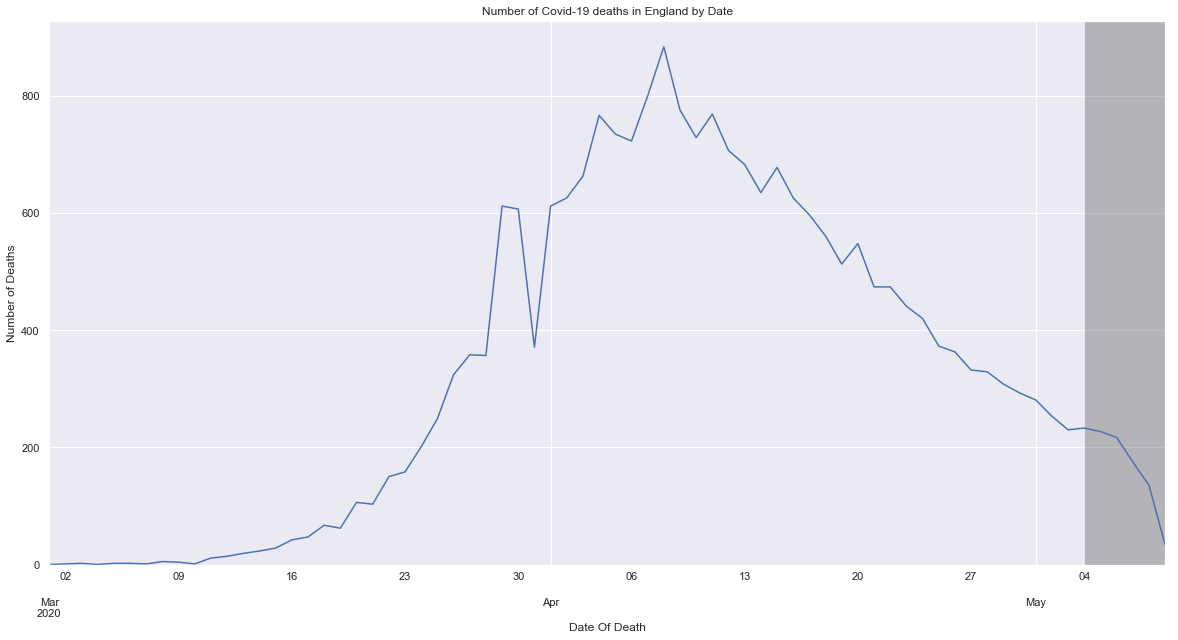

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

tot_plot = total_data.drop(['Total'], axis=1)
total_data_melt = pd.melt(tot_plot, id_vars=['NHS England Region'])
total_data_melt.rename(columns={"variable": "Date Of Death", "value": "Number Of Deaths"},inplace=True)
total_data_melt.set_index('Date Of Death',inplace=True)

daily_plot = daily_data_all.drop(['Total'], axis=1)
daily_data_melt = pd.melt(daily_plot, id_vars=['NHS England Region', 'Date Reported'])
daily_data_melt.rename(columns={"variable": "Date Of Death", "value": "Number Of Deaths"},inplace=True)
daily_data_melt['Date Reported'] = daily_data_melt['Date Reported'].astype('datetime64[ns]') 
daily_data_melt['Lag'] = daily_data_melt['Date Reported'] - daily_data_melt['Date Of Death']
daily_data_melt.set_index('Date Of Death',inplace=True)

nat = total_data_melt[total_data_melt['NHS England Region'] == 'England']

sns.set()

plt.subplots(figsize=(20,10))
chart = nat["Number Of Deaths"].plot()
chart.set_title('Number of Covid-19 deaths in England by Date')
chart.set_ylabel('Number of Deaths')
chart.axvspan(max(nat.index) - timedelta(days=5), max(nat.index), facecolor='grey', alpha=0.5)
chart.set_ylim(bottom=0)
chart.set_xlim(left=min(nat.index), right=max(nat.index))

chart


Now we split that down by region. Again, all the plots below are affected by the lag in the reporting of the data.


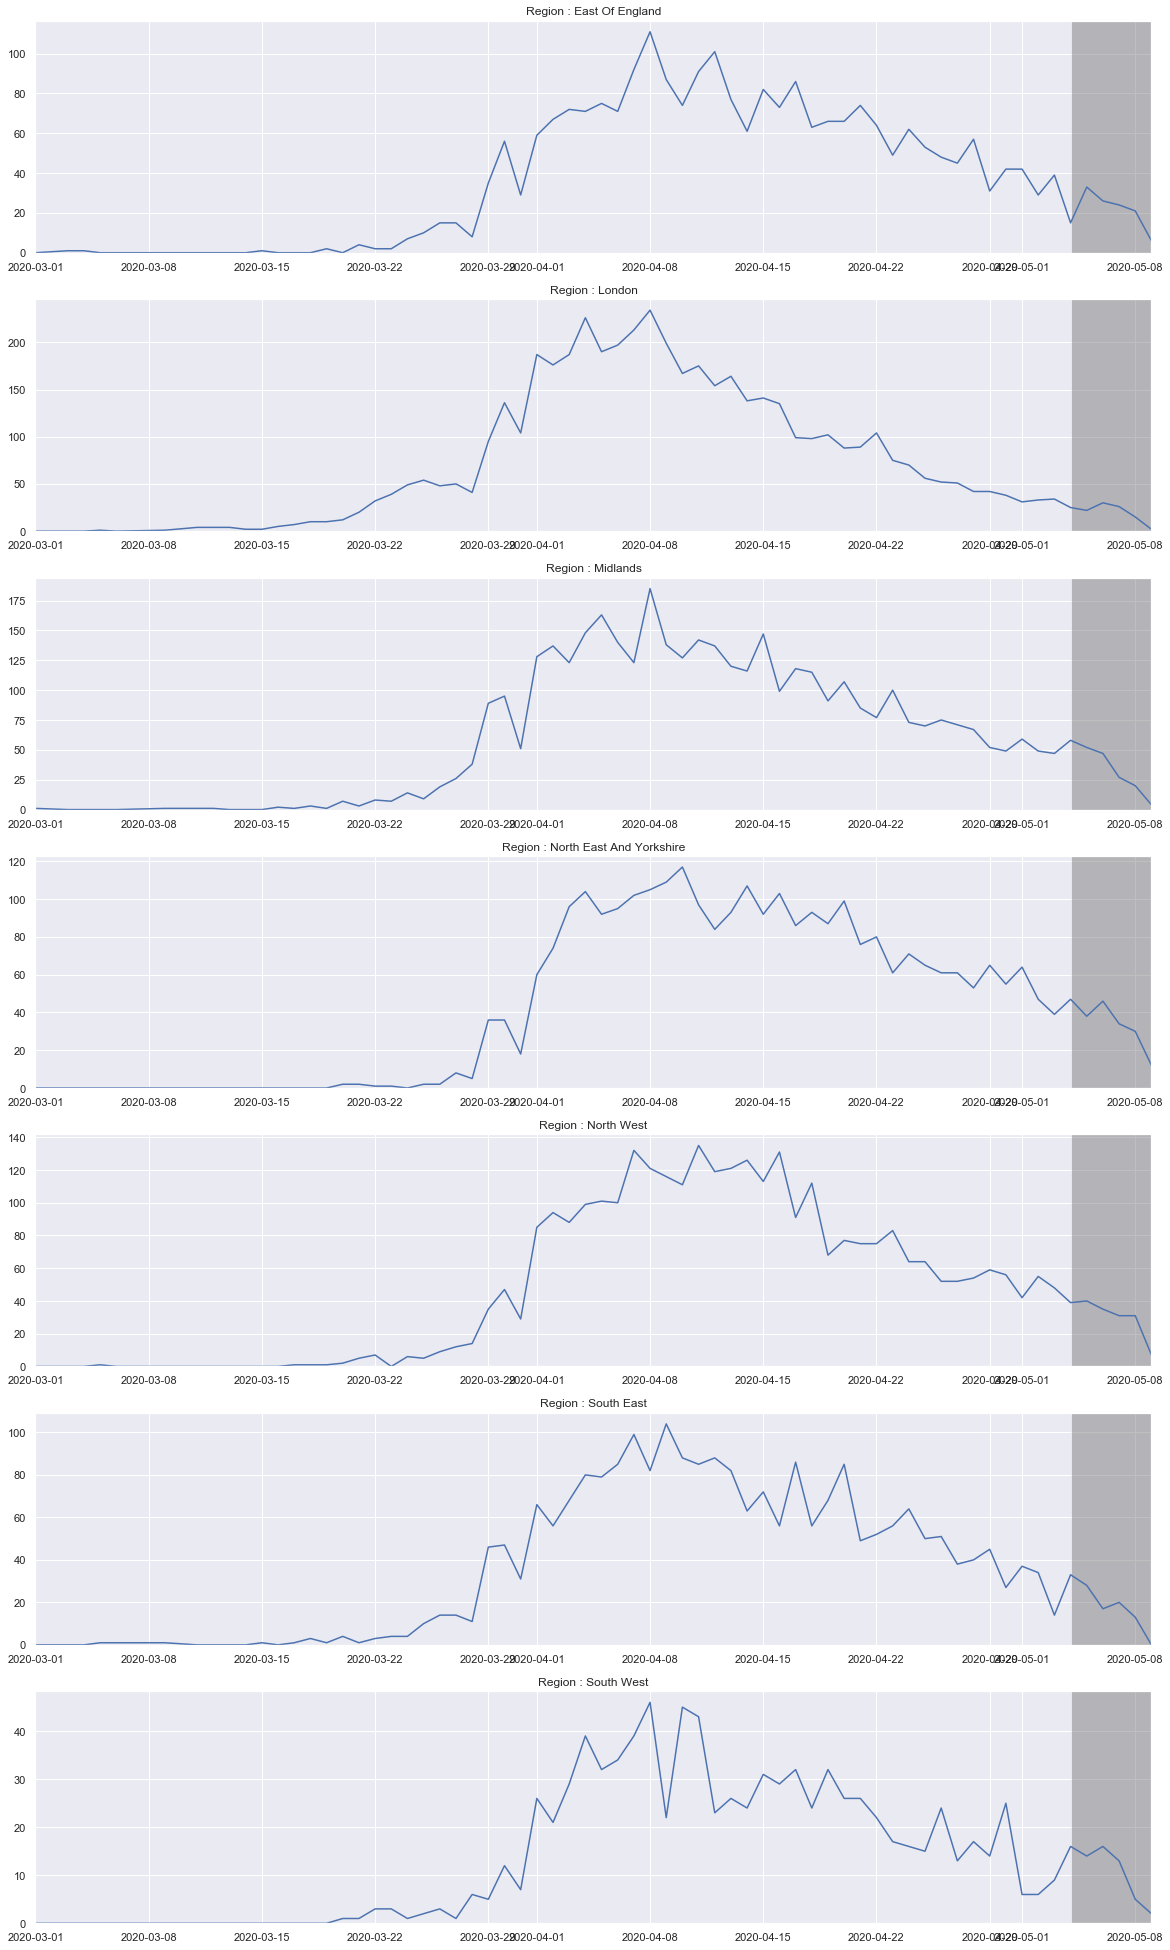

In [3]:
regions = daily_data_melt[(daily_data_melt['NHS England Region'] != 'England') 
                          & (daily_data_melt['Lag'] > timedelta(days=0))]

regions_plot = regions.groupby(['Date Of Death','NHS England Region']).sum().reset_index().set_index('Date Of Death')
region_list = regions_plot['NHS England Region'].unique().tolist()

fig, ax = plt.subplots(len(region_list),figsize=(20,35))

for pointer in range(len(region_list)):
    to_plot = regions_plot.loc[regions_plot['NHS England Region'] == region_list[pointer],["Number Of Deaths"]]
    ax[pointer].plot(to_plot['Number Of Deaths'])
    ax[pointer].set_title('Region : {0}'.format(region_list[pointer]))
    ax[pointer].axvspan(max(nat.index) - timedelta(days=5), max(nat.index), facecolor='grey', alpha=0.5)
    ax[pointer].set_ylim(bottom=0)
    ax[pointer].set_xlim(left=min(nat.index), right=max(nat.index))


### Lag in Reporting

Here we start to look at the break down of reporting lag, by the date of the death. Unfortunately, this data only started being produced on 2nd April, so the number of days is limited to where we have 'full' data about the lags.

We can also note, that there are still some relatively big numbers that are being reported up to 9-10 days after the date of death. First off we look at recorded number of deaths by lag in reporting.

In [4]:
daily_lags = daily_data_melt[(daily_data_melt['NHS England Region'] == 'England') 
                             & (daily_data_melt['Lag'] >= timedelta(days=0))
                             & (daily_data_melt['Number Of Deaths'] > 0)]

# Cap the lag at 14 days as most should be reported by then

daily_lags.loc[daily_lags['Lag'] >= timedelta(days=14),'Lag'] = timedelta(days=14)
lags = daily_lags.groupby([daily_lags.index,'Lag']).sum()
tots = daily_lags.groupby([daily_lags.index]).sum()
lags = pd.merge(lags, tots.rename(columns={'Number Of Deaths':'Total Deaths'}), how='inner', left_index=True, right_index=True)
lags['Proportion Of Deaths'] = lags['Number Of Deaths'] / lags['Total Deaths']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


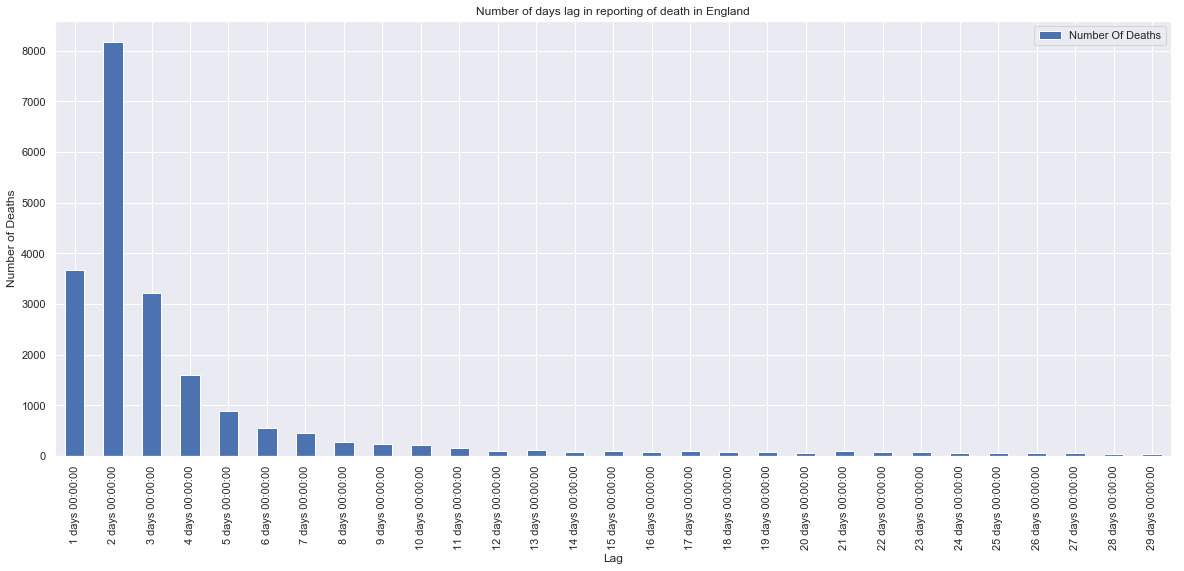

In [5]:
chart = (daily_data_melt.loc[(daily_data_melt['NHS England Region'] == 'England') 
                             & (daily_data_melt['Lag'] >= timedelta(days=1)) 
                             & (daily_data_melt['Lag'] < timedelta(days=30))
        ,['Number Of Deaths','Lag']]
    .groupby(['Lag'])
    .sum()
    .plot
    .bar(figsize=(20,8)))

chart.set_title('Number of days lag in reporting of death in England')
chart.set_ylabel('Number of Deaths')

chart

Next we can see the number of deaths by date of death, split down by the lag in the reporting. In the chart below, note that the 1st is the day when our 1 day lag starts as this is when the data was first available, and for the more recent data we dont have higher lags because these are yet to be reported.

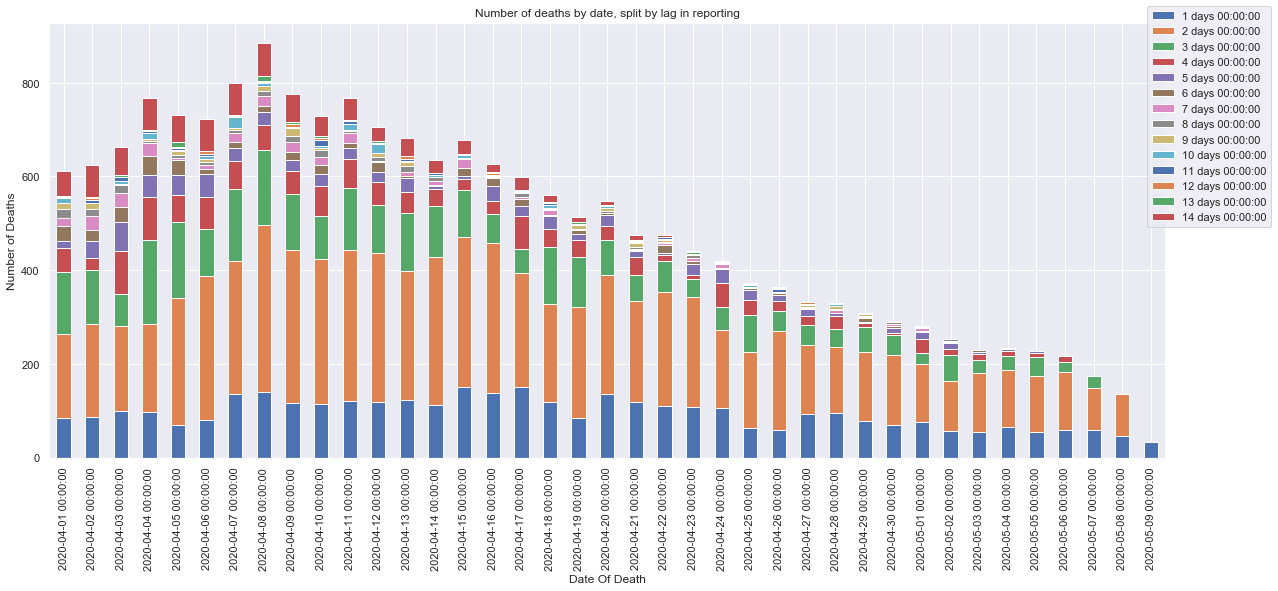

In [6]:
lag_plot = lags['Number Of Deaths'].unstack()
chart = lag_plot['2020-04-01':].plot.bar(stacked=True,figsize=(20,8))

chart.set_title('Number of deaths by date, split by lag in reporting')
chart.set_ylabel('Number of Deaths')
chart.legend(bbox_to_anchor=(1.1, 1.05))

chart

We can see there is some sort of stability in the proportions getting reported by lag of reporting. Lets examine the dates where we have what looks like more extensive data

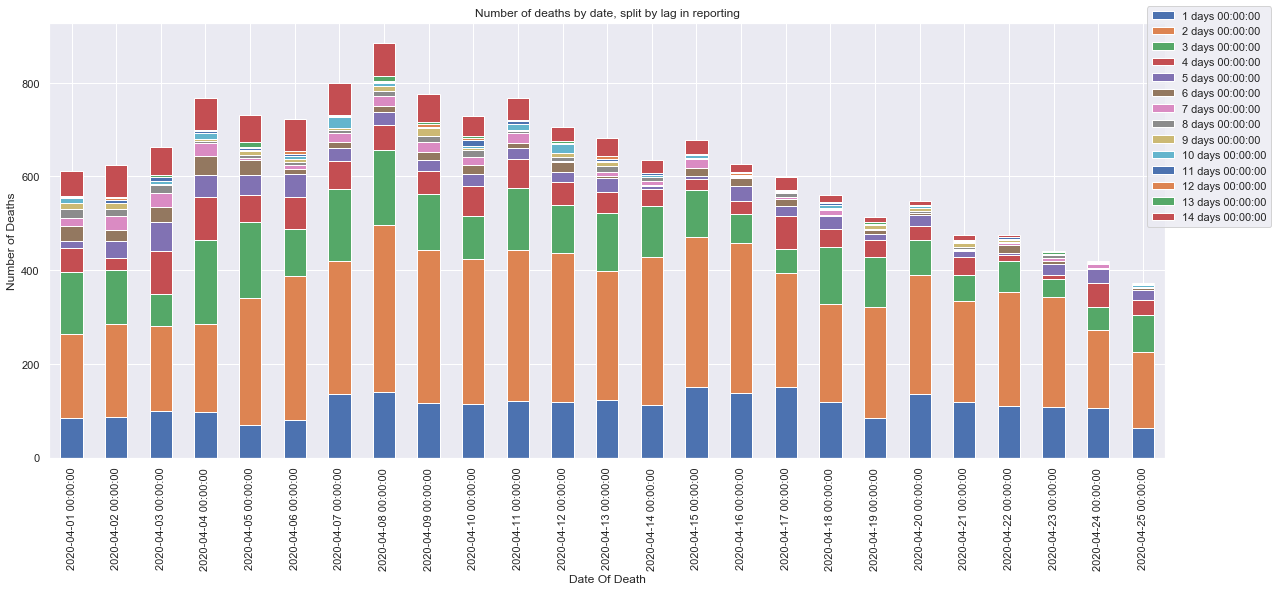

In [7]:
chart = lag_plot['2020-04-01':(max(lag_plot.index)-timedelta(days=14))].plot.bar(stacked=True,figsize=(20,8))

chart.set_title('Number of deaths by date, split by lag in reporting')
chart.set_ylabel('Number of Deaths')
chart.legend(bbox_to_anchor=(1.1, 1.05))

chart

Looking at this by proportion we get the following.

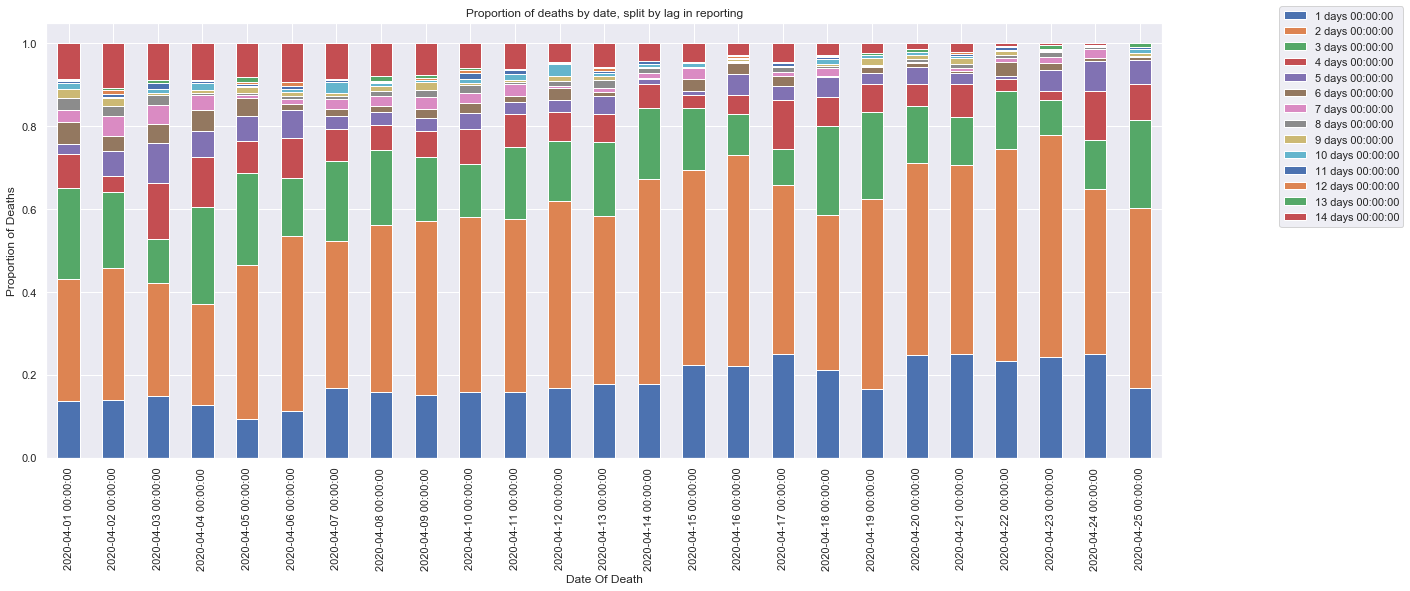

In [8]:
lag_plot = lags['Proportion Of Deaths'].unstack()
chart = lag_plot['2020-04-01':(max(lag_plot.index)-timedelta(days=14))].plot.bar(stacked=True,figsize=(20,8))

chart.set_title('Proportion of deaths by date, split by lag in reporting')
chart.set_ylabel('Proportion of Deaths')
chart.legend(bbox_to_anchor=(1.1, 1.05))

chart

### Estimating recent days actual number of deaths

We can then get a naive estimate of the total number of deaths per date, based upon the data that has been recorded. Our naive estimate will take the avarage proportion above and extrapolate to try and get something more realistic.

In [9]:
naive_prop = (daily_data_melt.loc[(daily_data_melt['NHS England Region'] == 'England') 
                             & (daily_data_melt['Lag'] >= timedelta(days=1))
        ,['Number Of Deaths','Lag']]
    .groupby(['Lag'])
    .sum())

total_deaths = naive_prop.sum()

naive_prop['Proportion Of Deaths'] = naive_prop.cumsum() / total_deaths

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


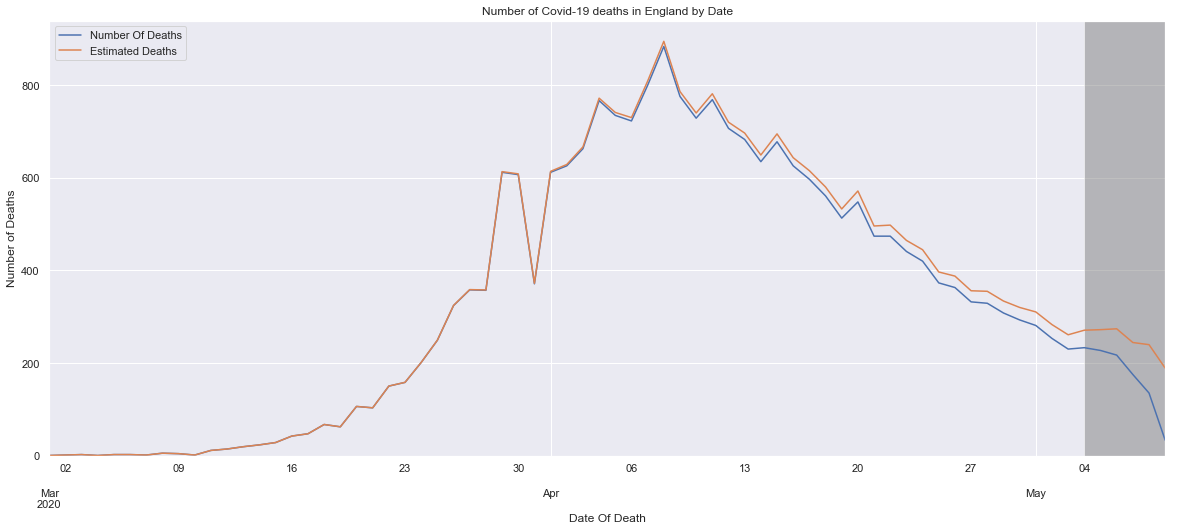

In [10]:
nat['Lag'] = max(nat.index) - nat.index + timedelta(days=1)

naive_est = nat.reset_index().merge(naive_prop[['Proportion Of Deaths']], how="left", left_on='Lag', right_on='Lag').set_index('Date Of Death')

naive_est['Estimated Deaths'] = naive_est['Number Of Deaths'] / naive_est['Proportion Of Deaths']

chart = naive_est[["Number Of Deaths","Estimated Deaths"]].plot(figsize=(20,8))
chart.set_title('Number of Covid-19 deaths in England by Date')
chart.set_ylabel('Number of Deaths')
chart.axvspan(max(naive_est.index) - timedelta(days=5), max(naive_est.index), facecolor='grey', alpha=0.5)
chart.set_ylim(bottom=0)
chart.set_xlim(left=min(naive_est.index), right=max(naive_est.index))

chart

Finally, we'll look at the above plot by region. Note of caution - the counts are getting very low, so the estimates will be quite uncertain, but it may give us a picture of the trend in the region. However, there may be different rates of reporting in each region which haven't been looked into, so take the plots below with a pinch of salt.

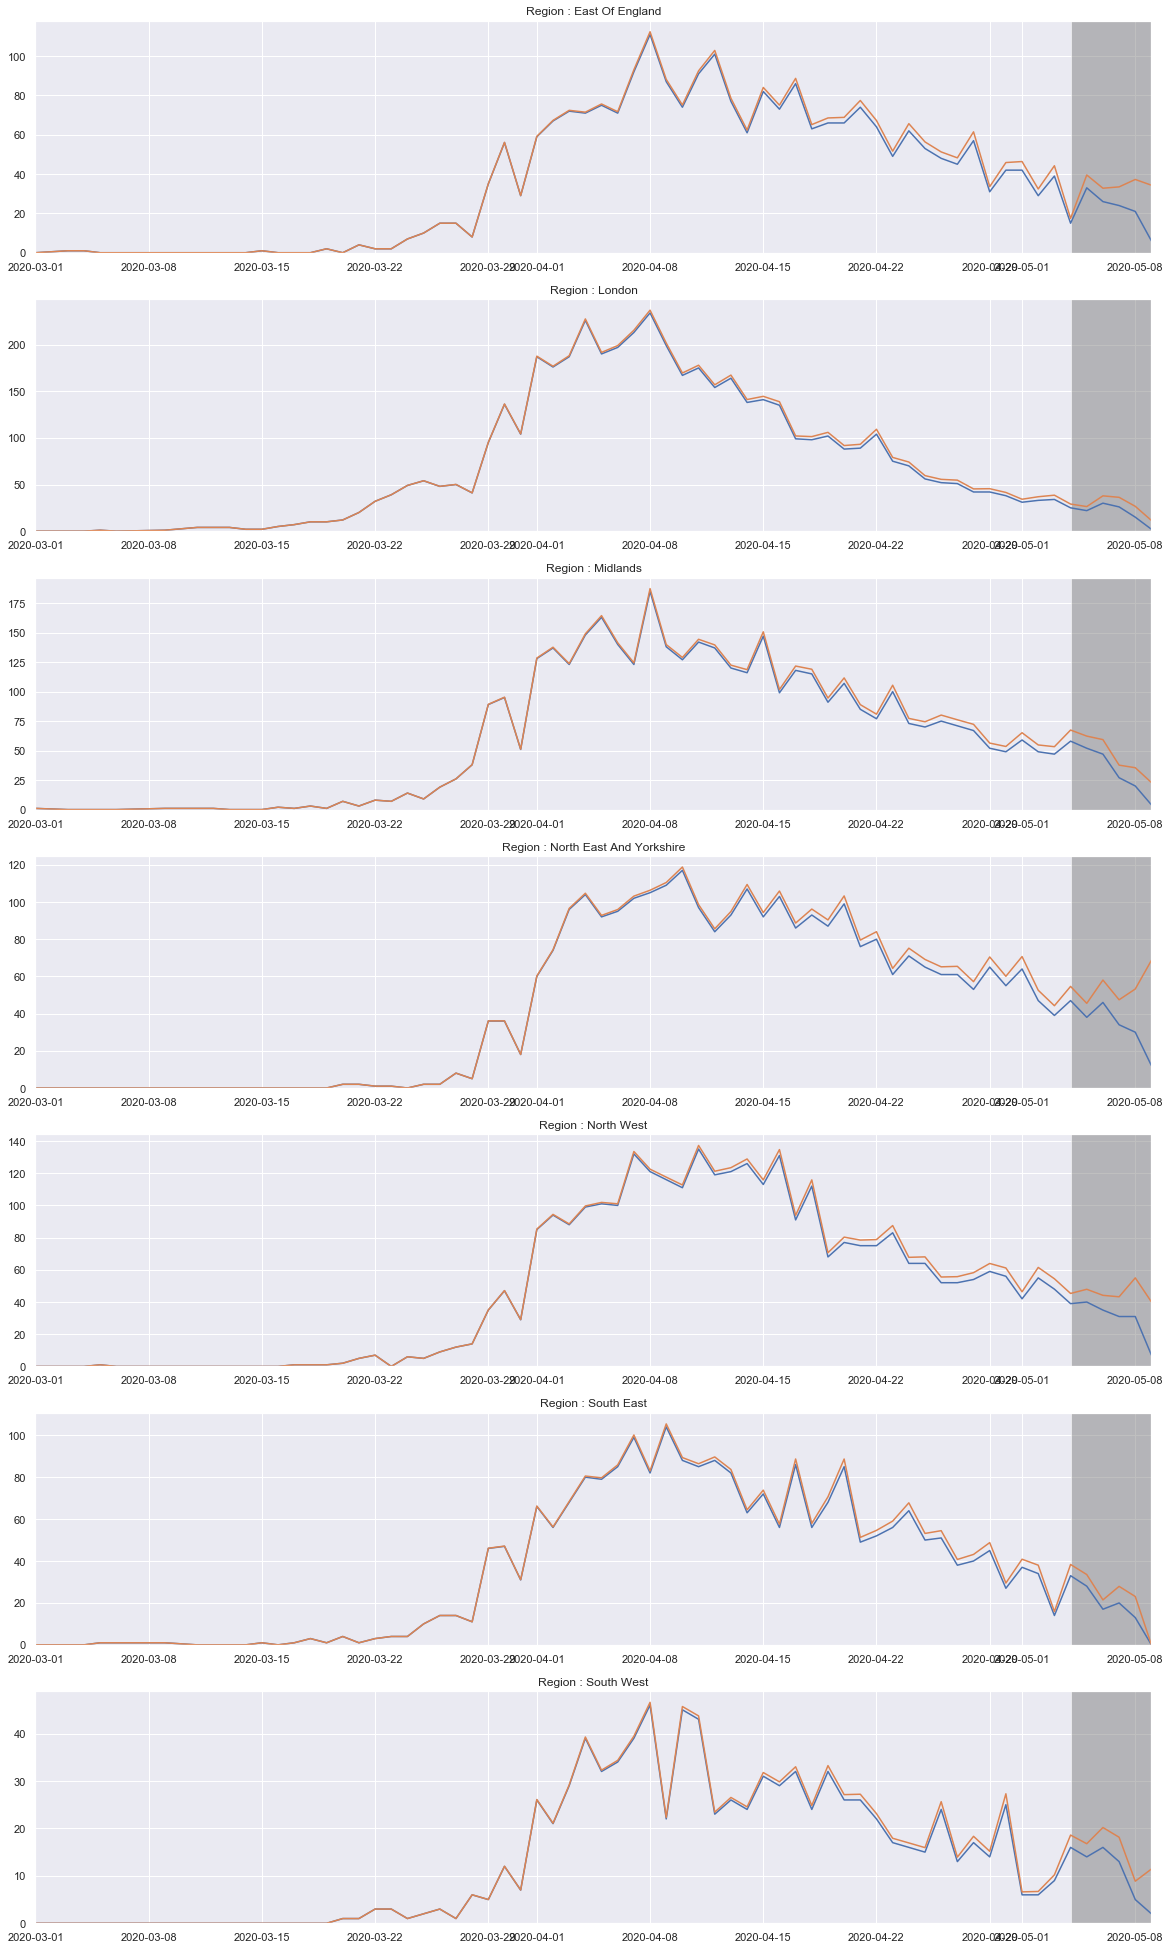

In [11]:
regions_plot['Lag'] = max(regions_plot.index) - regions_plot.index + timedelta(days=1)
naive_est_region = regions_plot.reset_index().merge(naive_prop[['Proportion Of Deaths']], how="left", left_on='Lag', right_on='Lag').set_index('Date Of Death')

naive_est_region['Estimated Deaths'] = naive_est_region['Number Of Deaths'] / naive_est_region['Proportion Of Deaths']

fig, ax = plt.subplots(len(region_list),figsize=(20,35))

for pointer in range(len(region_list)):
    to_plot = naive_est_region.loc[regions_plot['NHS England Region'] == region_list[pointer],["Number Of Deaths",'Estimated Deaths']]
    ax[pointer].plot(to_plot[['Number Of Deaths','Estimated Deaths']])
    ax[pointer].set_title('Region : {0}'.format(region_list[pointer]))
    ax[pointer].axvspan(max(nat.index) - timedelta(days=5), max(nat.index), facecolor='grey', alpha=0.5)
    ax[pointer].set_ylim(bottom=0)
    ax[pointer].set_xlim(left=min(nat.index), right=max(nat.index))


From this point of view (nationally), it looks like we are somewhere near the top of the first peak, if not a little after (18th April). This is a very basic analysis, but it demostrates that how quickly deaths are reported makes it harder to guage at which point in the crisis we are currently at. I think this also shows that there is lockdown isnt going to end until the numbers are definitely on the way down.

However, a much earlier indication is probably the hospital admissions dataset, as the data that we are tracking here is at the end of the cycle. The hospital admissions dataset probably has a higher impact on policy and the easing of restraints as is an earlier indicator of general incidence.

This analysis could be extended in a number of ways:
* Add a level of uncertainty to the estimate
* The reporting seems to differ on a seasonal (weekly) basis, this should be explored further
* We can try and build a more complex estimate, which takes into account day of week etc.
* Currently there is a question over whether the outbreak is affecting BAME communities harder. We could look at the figures of ethnicity in each NHS trust from the census, and weight this by number of deaths in each trust to look at overall proportion, and see whether it is indeed a higher proportion of BAME dying from covid than in the areas where it is currently prevalent.